In [171]:
import matplotlib.pyplot as plt
import numpy as np
import ugradio as ug
import scipy.constants as consts

In [172]:
sundata = np.load('Sun2019final.npz')

In [173]:
times = sundata['time']
volts = sundata['volts']

In [174]:
plt.plot(times - times[0], volts)
plt.ylabel('Voltage (V)')
plt.xlabel('Time Since Observation Began (s)')
plt.show()

In [175]:
unixtime = times
JDtime = ug.timing.julian_date(unixtime)
LSTtime = ug.timing.lst(jd = JDtime)*180/np.pi #convert LSTtime from rad to deg

In [176]:
#ra = [ug.coord.sunpos(time)[0] for time in JDtime]
#np.savez('SunRAvalues.npz', data=ra)

In [177]:
ra = np.load('SunRAvalues.npz')['data']

In [194]:
h2 = LSTtime - ra
L = ug.coord.nch.lat*np.pi/180
l = consts.c/10.7e9
d = ug.coord.sunpos(JDtime[0])[1]*np.pi/180

In [195]:
h = []
for val in h2:
    if val < 0:
        h.append(val+360)
    else:
        h.append(val)

<IPython.core.display.Javascript object>


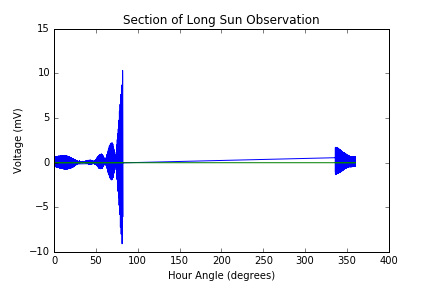

In [196]:
def f(x):
    return np.mean(x)*np.ones(len(x))
%matplotlib notebook
plt.plot(h, volts*1000)
plt.plot(h, f(volts))
plt.title("Section of Long Sun Observation")
plt.ylabel("Voltage (mV)")
plt.xlabel("Hour Angle (degrees)")
plt.savefig("sunsectionall.png")
plt.show()

### Baseline Fitting

In [197]:
hsmall = h[6000:10000]
voltssmall = volts[6000:10000]

In [201]:
hsmall = np.array(h)
voltssmall = volts

In [202]:
L

0.6610120208130239

In [203]:
ewvals = np.linspace(18, 22, 200)
nsvals = np.linspace(0, 3, 150)
avals = np.empty((len(ewvals), len(nsvals)), dtype=object)
s = np.empty((len(ewvals), len(nsvals)))
var = np.empty((len(ewvals), len(nsvals)), dtype=object)
Y = voltssmall
Y.shape = (-1, 1)
for i in range(len(ewvals)):
    for j in range(len(nsvals)):
        Bew = ewvals[i]
        Bns = nsvals[j]
        Qew = Bew*np.cos(d)/l
        Qns = Bns*np.sin(L)*np.cos(d)/l
        nutaug = Qew*np.sin(hsmall*np.pi/180) + Qns*np.cos(hsmall*np.pi/180)
        aterm = np.cos(2*np.pi*nutaug)
        bterm = np.sin(2*np.pi*nutaug)
        Xt = np.vstack((aterm, bterm))
        X = Xt.T
        xx = np.dot(Xt, X)
        xy = np.dot(Xt, Y)
        xxi = np.linalg.inv(xx)
        a = np.dot(xxi, xy)
        avals[i,j] = tuple(a)
        ybar = np.dot(X, a)
        dely = Y - ybar
        s_sq = np.dot(dely.T, dely)/(len(Y) - 2)
        s[i,j] = s_sq
        dxxi = np.diag(xxi)
        vardc = s_sq*dxxi
        var[i,j] = tuple(vardc)
    if (i%10 == 0):
        print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [204]:
minns = [(min(x), list(x).index(min(x))) for x in s]
nsindex = [x[1] for x in minns]
svals = [x[0] for x in minns]
ewindexval = list(svals).index(min(svals))
indexval = (ewindexval, nsindex[ewindexval])

In [205]:
indexval

(0, 123)

In [206]:
print(ewvals[indexval[0]])
print(nsvals[indexval[1]])

18.0
2.47651006711


For indexes 6000:10000 19.2060301508
0.0201342281879
variances [  9.95558341e-11,   1.04675697e-10]

indicies 6000:12000  18.0 and 1.20805369128 variances [  4.82437390e-11,   4.84380788e-11]

all indicies 

In [111]:
3*np.sqrt(var[indexval])

array([[  3.78022651e-05,   3.71512644e-05]])

<IPython.core.display.Javascript object>


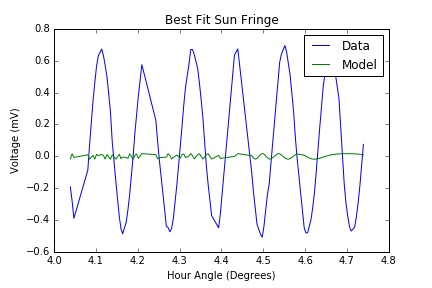

In [97]:
%matplotlib notebook
Bew = ewvals[indexval[0]]
Bns = nsvals[indexval[1]]
Qew = Bew*np.cos(d)/l
Qns = Bns*np.sin(L)*np.cos(d)/l
nutaug = Qew*np.sin(hsmall) + Qns*np.cos(hsmall)
aterm = np.cos(2*np.pi*nutaug)
bterm = np.sin(2*np.pi*nutaug)
A, B = avals[indexval]
plt.plot(hsmall[100:200], voltssmall[100:200]*1000, label='Data')
plt.plot(hsmall[100:200], (A*aterm+B*bterm)[100:200]*1000, label='Model')
plt.legend()
plt.ylabel('Voltage (mV)')
plt.xlabel('Hour Angle (Degrees)')
plt.title('Best Fit Sun Fringe')
plt.savefig('VoltageFit12000.png')
plt.show()

### Diameter Fitting

In [112]:
#x = 2*pi*R*u #find x values of crossings
# convert to u values
# use formula to solve for R
#u = bx*cos(h)/l

In [186]:
bx = 20
l = consts.c/10.7e9
hnulls = np.array([np.mean([73.2, 74.1]), np.mean([60.795, 61.589]), np.mean([46.7368, 48.5508])])
x = [-3.8317, -7.0156, -10.1735]
u = bx*np.cos(hnulls*np.pi/180)/l
R = x/(2*np.pi*u)

<IPython.core.display.Javascript object>


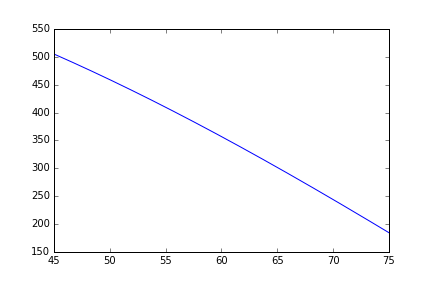

In [190]:
xvals = np.linspace(45, 75, 2000)
y = bx*np.cos(xvals*np.pi/180)/l
plt.plot(xvals, y)
plt.show()

<IPython.core.display.Javascript object>


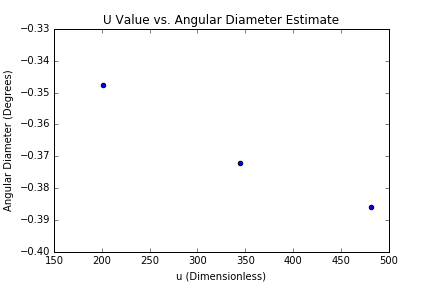

In [191]:
plt.scatter(u, 2*180*R/np.pi)
plt.title('U Value vs. Angular Diameter Estimate')
plt.ylabel('Angular Diameter (Degrees)')
plt.xlabel('u (Dimensionless)')
plt.show()

In [170]:
np.mean(2*180*np.array([R[0], R[2]])/np.pi)

0.42708363152810375